# 7. Advanced Calculation and Statistical Methods

## Regridding

Different datasets usually have different time and grid resolutions. Sometimes we need to use different datasets with the same resolution, so we need to regrid the `A` grid onto the `B` grid resolution. The simplest way to do this with xarray is using `xr.interp`. The default interpolation method of the `xr.interp` function is linear interpolation.

**Example 1:** The horizontal resolution of GPCP rainfall data is 2.5˚, and the horizontal resolution of OLR is 1˚. Now we will regrid the OLR data to the GPCP resolution.


In [1]:
import xarray as xr
lats = -20
latn =  30
lon1 =  79 
lon2 = 161

pcp_ds = xr.open_dataset('data/gpcp_precip_1979-2019.pentad.nc') 
pcp = pcp_ds.sel(lat=slice(latn,lats), lon=slice(lon1,lon2)).data
olr_ds = xr.open_dataset('data/olr.nc')
olr = olr_ds.sel(lat=slice(lats,latn), lon=slice(lon1,lon2)).olr

olr_rmp = olr.interp(lon=pcp.lon, lat=pcp.lat)   # Specify the target grid info to the `interp` method. 
olr_rmp

<xarray.DataArray 'olr' (time: 8760, lat: 20, lon: 32)> Size: 22MB
array([[[210.37125, 199.29874, 197.44077, ..., 268.05853, 268.25916,
         266.9823 ],
        [204.61313, 213.93433, 230.92719, ..., 284.24072, 282.60632,
         278.35385],
        [236.69272, 247.62692, 259.35587, ..., 294.86554, 292.45862,
         292.01804],
        ...,
        [297.27472, 302.5027 , 305.18634, ..., 193.11395, 206.42505,
         197.59212],
        [291.31464, 291.11176, 298.43726, ..., 155.4393 , 146.58469,
         162.1478 ],
        [286.89136, 290.6887 , 291.20618, ..., 171.58977, 183.45123,
         195.39035]],

       [[259.8478 , 225.8486 , 211.98647, ..., 269.50348, 269.39746,
         272.64   ],
        [276.39136, 272.1738 , 268.95856, ..., 291.94778, 289.79297,
         284.37097],
        [260.77368, 265.89886, 275.41898, ..., 301.7583 , 299.66028,
         292.9348 ],
...
        [289.9028 , 281.8377 , 285.37466, ..., 169.81645, 173.29109,
         213.98285],
        [286.0285 , 282.36426, 284.31454, ..., 111.96492, 154.03249,
         224.03793],
        [290.05353, 295.02466, 291.87067, ..., 125.69296, 153.77583,
         191.87067]],

       [[240.00652, 211.87251, 198.56546, ..., 264.23984, 258.3333 ,
         255.25803],
        [224.23218, 243.02698, 246.38681, ..., 279.6334 , 274.43097,
         277.21472],
        [234.04726, 253.98969, 263.0449 , ..., 289.64203, 291.71185,
         293.91864],
        ...,
        [286.8454 , 287.29822, 284.08643, ..., 165.07278, 165.68568,
         180.77968],
        [291.43097, 289.64923, 295.36426, ..., 178.16243, 158.17258,
         182.52911],
        [294.91678, 297.96875, 296.73392, ..., 174.35318, 157.13422,
         152.69089]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 70kB 1998-01-01 1998-01-02 ... 2021-12-31
  * lon      (lon) float32 128B 81.25 83.75 86.25 88.75 ... 153.8 156.2 158.8
  * lat      (lat) float32 80B 28.75 26.25 23.75 21.25 ... -13.75 -16.25 -18.75
Attributes:
    standard_name:  toa_outgoing_longwave_flux
    long_name:      NOAA Climate Data Record of Daily Mean Upward Longwave Fl...
    units:          W m-2
    cell_methods:   time: mean area: mean

However, sometimes linear interpolation is not the best way to regrid. For example, rainfall need to stay mass conservation after regridding, therefore **conservative** regridding is required. Here we introduce `xesmf` library to do this. 

**Example 2:** Regrid the GPCP data to the OLR resolution.

In [2]:
import xesmf as xe

# Set the grid information 
grid_olr  = xr.Dataset({'lat':olr.lat, 'lon':olr.lon}) 
grid_gpcp = xr.Dataset({'lat':pcp.lat, 'lon':pcp.lon}) 
# ds_in: the input grid info; 
# ds_out: the output grid info
regridder = xe.Regridder(ds_in=grid_gpcp , ds_out=grid_olr, method="conservative_normed")
pcp_rg = regridder(pcp,keep_attrs=True)

KeyError: 'Author'

## Coarsen Grid Resolution

We can also coarsen the grid resolution using `xarray.DataArray.coarsen`. 

**Example 3:** Convert daily OLR data to pentad mean. (This means to coarsen the grid resolution from daily to pentad.)

In [3]:
olr_noleap = olr.sel(time=~((olr.time.dt.month == 2) & (olr.time.dt.day == 29))) # Remove the leap days.
olr_ptd = (olr_noleap.coarsen(time=5,
                              coord_func={"time": "min"})  # Set the coordinate values to the min. of the 5-day period 
                                                           # (or the pentad start day)
                     .mean())
olr_ptd

<xarray.DataArray 'olr' (time: 1752, lat: 50, lon: 82)> Size: 29MB
array([[[284.27383, 285.73615, 288.25266, ..., 231.88799, 241.6569 ,
         249.84024],
        [286.65228, 288.0508 , 288.27435, ..., 215.95383, 230.82944,
         246.1481 ],
        [290.7838 , 290.2586 , 287.82904, ..., 198.27681, 214.98921,
         225.9622 ],
        ...,
        [247.29614, 246.06245, 247.9498 , ..., 279.0298 , 277.99088,
         276.57684],
        [244.55948, 242.81021, 239.57669, ..., 273.2099 , 271.63373,
         270.99365],
        [236.1903 , 229.96805, 221.43008, ..., 266.5147 , 266.81476,
         266.7093 ]],

       [[257.097  , 249.0689 , 260.7727 , ..., 251.24785, 258.4394 ,
         267.57504],
        [265.49664, 263.9062 , 270.4431 , ..., 237.29636, 248.2174 ,
         250.10226],
        [261.7508 , 266.22888, 276.74783, ..., 222.4416 , 235.64157,
         227.53247],
...
        [246.52588, 246.06046, 249.06099, ..., 256.54034, 259.21564,
         260.40427],
        [244.2377 , 247.02632, 246.57185, ..., 258.28464, 255.90445,
         257.71054],
        [237.54703, 235.23251, 224.96394, ..., 255.28891, 253.66435,
         255.53586]],

       [[286.864  , 287.83688, 290.30945, ..., 194.66502, 212.79057,
         210.36748],
        [288.31   , 288.92453, 290.12537, ..., 204.64694, 225.9674 ,
         223.37724],
        [284.80383, 288.20563, 289.7766 , ..., 215.14029, 236.13554,
         232.43852],
        ...,
        [236.44717, 236.95544, 234.64787, ..., 268.50082, 268.91937,
         267.25333],
        [235.04623, 231.87952, 229.08992, ..., 267.69647, 267.49542,
         266.0851 ],
        [233.44182, 225.93411, 211.10928, ..., 268.23108, 265.9177 ,
         264.84662]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 14kB 1998-01-01 1998-01-06 ... 2021-12-27
  * lon      (lon) float32 328B 79.5 80.5 81.5 82.5 ... 157.5 158.5 159.5 160.5
  * lat      (lat) float32 200B -19.5 -18.5 -17.5 -16.5 ... 26.5 27.5 28.5 29.5
Attributes:
    standard_name:  toa_outgoing_longwave_flux
    long_name:      NOAA Climate Data Record of Daily Mean Upward Longwave Fl...
    units:          W m-2
    cell_methods:   time: mean area: mean

We actually average the time coordinate over every 5 days. The default setting of `coord_func` is `mean`, where the coarsened coordinate will be set as the date of the 5-day average (e.g., 1998-01-03, 1998-01-08, 1998-01-13, ...). Other options include `min` (the start date of the pentad) or `max` (the end date of the pentad).

```{note}
`xarray.DataArray.resample` seems to have the same function. From API reference,

> The resampled dimension must be a datetime-like coordinate.

First of all, `coarsen` can be operated on any coordinate, whereas `resample` can only be operated on a datetime-like coordinate. Additionally, we cannot skip leap days since the resample frequency is entirely based on the datetime object (See [this StackOverflow post](https://stackoverflow.com/questions/64476727/can-we-assign-the-calendar-of-pandas-datetimeindex-as-noleap-or-can-datetime)). Therefore, `olr_ptd = olr_noleap.resample(time='5D')` will still consider Feb. 29 even if we exclude leap days in the data.
```

## Running Mean

Running mean is often applied to remove or smooth out high-frequency variability. For example, Takaya and Nakamura (2001, JAS) used a 10-day running mean to remove high-frequency variability within a 10-day period before calculating the Rossby wave activity flux. When calculating Realtime Multivariate MJO (RMM) index, Gottschalck et al. (2010, BAMS) removed interannual variability by subtracting the 120-day running mean before performing the combined EOF analysis. In xarray, we can use the `xarray.DataArray.rolling` method to calculate the running mean.


In [4]:
olr_3p_runave = (olr_ptd.rolling(time=3,        
                                 center=False)
                        .mean()
                        .dropna('time'))
olr_3p_runave

<xarray.DataArray 'olr' (time: 1750, lat: 50, lon: 82)> Size: 29MB
array([[[267.31717, 266.99036, 270.8208 , ..., 247.27075, 253.0514 ,
         259.74832],
        [272.3418 , 271.4567 , 273.70862, ..., 235.08034, 243.3069 ,
         250.87163],
        [270.9473 , 272.3905 , 274.61237, ..., 223.71478, 231.73334,
         233.63165],
        ...,
        [242.48238, 243.38196, 246.27788, ..., 271.20895, 271.14975,
         270.8715 ],
        [239.12952, 239.81575, 242.67973, ..., 266.25696, 266.15314,
         266.28625],
        [234.36653, 231.1346 , 223.61658, ..., 259.56998, 260.0516 ,
         260.38214]],

       [[264.36322, 261.904  , 264.3725 , ..., 238.1038 , 241.9434 ,
         249.87357],
        [269.2213 , 267.343  , 269.49976, ..., 232.33305, 237.68199,
         241.17148],
        [266.89197, 267.56128, 270.72424, ..., 229.26079, 234.51195,
         233.8206 ],
...
        [258.01865, 258.54132, 260.59457, ..., 265.62262, 266.46997,
         267.72852],
        [254.52092, 255.43341, 253.74515, ..., 262.07703, 262.12787,
         264.36252],
        [249.05486, 243.50095, 230.53357, ..., 257.8312 , 259.1329 ,
         259.55786]],

       [[285.45612, 286.57214, 287.6652 , ..., 247.677  , 257.28473,
         259.3609 ],
        [288.13184, 288.3128 , 289.0145 , ..., 255.27068, 264.8253 ,
         264.77902],
        [288.0848 , 289.45697, 289.93057, ..., 261.4938 , 269.81818,
         268.2691 ],
        ...,
        [248.90976, 249.10083, 250.33572, ..., 262.9018 , 263.4146 ,
         263.58185],
        [247.00436, 247.02068, 245.05011, ..., 261.76514, 261.24374,
         261.8905 ],
        [243.24814, 237.90851, 224.16135, ..., 258.3669 , 257.77066,
         257.97882]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 14kB 1998-01-11 1998-01-16 ... 2021-12-27
  * lon      (lon) float32 328B 79.5 80.5 81.5 82.5 ... 157.5 158.5 159.5 160.5
  * lat      (lat) float32 200B -19.5 -18.5 -17.5 -16.5 ... 26.5 27.5 28.5 29.5
Attributes:
    standard_name:  toa_outgoing_longwave_flux
    long_name:      NOAA Climate Data Record of Daily Mean Upward Longwave Fl...
    units:          W m-2
    cell_methods:   time: mean area: mean

We can use `dropna()` to remove missing values. 

## Correlation Map

We can calculate the correlation coefficient between two DataArrays along a specific coordinate.

**Example 4:** Plot the correlation coefficient map between NDJ [Oceanic Niño Index (ONI)](https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php) and December rainfall.

**Step 1:** Retrieve GPCP monthly mean rainfall in December. (Choose all data in December, then group and average by each year with `groupby`.)


In [5]:
pcp_dec = (pcp.sel(time=pcp.time.dt.month.isin([12]))
              .groupby('time.year')
              .mean("time"))
pcp_dec

<xarray.DataArray 'data' (year: 41, lat: 20, lon: 32)> Size: 105kB
array([[[1.0133333e+00, 9.1833329e-01, 7.9833335e-01, ...,
         3.6333334e+00, 2.7116668e+00, 2.5383332e+00],
        [2.0333333e-01, 4.2833331e-01, 2.5000000e-01, ...,
         2.4483333e+00, 2.3216665e+00, 1.7766665e+00],
        [5.4999996e-02, 1.3666667e-01, 1.5833335e-01, ...,
         2.2033336e+00, 1.8683332e+00, 1.2850000e+00],
        ...,
        [1.1466666e+00, 1.4949999e+00, 1.8333334e+00, ...,
         3.6483333e+00, 4.2433333e+00, 2.9916668e+00],
        [7.1833330e-01, 1.3866667e+00, 1.4466667e+00, ...,
         4.0750003e+00, 3.2466669e+00, 2.8599999e+00],
        [3.9666665e-01, 8.2333332e-01, 1.1883334e+00, ...,
         2.9016666e+00, 2.7083333e+00, 1.7416667e+00]],

       [[4.6500000e-01, 2.8333333e-01, 3.4333333e-01, ...,
         3.8716667e+00, 3.8799999e+00, 3.4633334e+00],
        [6.0833335e-01, 1.7000000e-01, 1.4666666e-01, ...,
         3.9750001e+00, 3.6300001e+00, 3.1483333e+00],
        [1.2800001e+00, 3.2166669e-01, 1.2000000e-01, ...,
         2.4466667e+00, 2.1550000e+00, 1.1616668e+00],
...
        [7.9235015e+00, 7.0794005e+00, 5.7172127e+00, ...,
         9.7668800e+00, 1.0939357e+01, 1.0846936e+01],
        [9.5492640e+00, 7.4848499e+00, 3.3095343e+00, ...,
         1.2228072e+01, 1.2528176e+01, 1.1302447e+01],
        [7.2531962e+00, 5.3915715e+00, 2.0546637e+00, ...,
         1.0486613e+01, 1.3482674e+01, 1.1387763e+01]],

       [[2.0096309e+00, 1.1509016e+00, 4.8980752e-01, ...,
         2.0202532e+00, 2.7056713e+00, 2.6676538e+00],
        [1.2896461e+00, 1.1470729e+00, 2.6983759e-01, ...,
         1.3239046e+00, 1.6525987e+00, 1.6284056e+00],
        [8.9463830e-01, 3.9747801e-01, 1.5476857e-01, ...,
         1.1533502e+00, 1.1403440e+00, 9.9328095e-01],
        ...,
        [1.2956619e+00, 6.6536534e-01, 5.8920252e-01, ...,
         4.1320643e+00, 4.3791137e+00, 4.1250496e+00],
        [1.7519032e+00, 1.2151116e+00, 9.6764684e-01, ...,
         5.1612849e+00, 5.1797566e+00, 2.8651981e+00],
        [3.1523111e+00, 2.0467207e+00, 1.0773114e+00, ...,
         3.6295269e+00, 4.3244128e+00, 2.4604805e+00]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 128B 81.25 83.75 86.25 88.75 ... 153.8 156.2 158.8
  * lat      (lat) float32 80B 28.75 26.25 23.75 21.25 ... -13.75 -16.25 -18.75
  * year     (year) int64 328B 1979 1980 1981 1982 1983 ... 2016 2017 2018 2019
Attributes:
    long_name:  GPCP pentad precipitation (mm/day)
    units:      mm/day

Step 2: Create the DataArray for NDJ ONI.

In [6]:
oni_ndj = xr.DataArray( 
                       data=[0.6, 0.0, -0.1, 2.2, -0.9, -1.1, -0.4, 1.2, 1.1, -1.8, -0.1, 0.4, 
                             1.5, -0.1, 0.1, 1.1, -1.0, -0.5, 2.4, -1.6, -1.7, -0.7, 
                             -0.3, 1.1, 0.4, 0.7, -0.8, 0.9, -1.6, -0.7, 1.6, -1.6, 
                             -1.0, -0.2, -0.3, 0.7, 2.6, -0.6, -1.0, 0.8, 0.5],
                       dims='year',
                       coords=dict(year=pcp_dec.year)
                       )
oni_ndj

<xarray.DataArray (year: 41)> Size: 328B
array([ 0.6,  0. , -0.1,  2.2, -0.9, -1.1, -0.4,  1.2,  1.1, -1.8, -0.1,
        0.4,  1.5, -0.1,  0.1,  1.1, -1. , -0.5,  2.4, -1.6, -1.7, -0.7,
       -0.3,  1.1,  0.4,  0.7, -0.8,  0.9, -1.6, -0.7,  1.6, -1.6, -1. ,
       -0.2, -0.3,  0.7,  2.6, -0.6, -1. ,  0.8,  0.5])
Coordinates:
  * year     (year) int64 328B 1979 1980 1981 1982 1983 ... 2016 2017 2018 2019

Step 3: Calculate correlation coefficient with `xr.corr`.

In [7]:
corr = xr.corr(pcp_dec,oni_ndj,dim='year')
corr

<xarray.DataArray (lat: 20, lon: 32)> Size: 5kB
array([[ 3.62929452e-01,  3.42366935e-01,  1.36141385e-01,
         2.86181885e-01,  1.81635007e-01,  1.49191933e-01,
         2.91984747e-01,  4.77790103e-01,  4.72934980e-01,
         2.59950214e-01,  3.45925729e-01,  3.45836394e-01,
         2.41839289e-01,  3.26920710e-01,  3.12002374e-01,
         2.78955901e-01,  2.83943380e-01,  3.95803478e-01,
         4.20742082e-01,  4.71375054e-01,  5.46175408e-01,
         4.34086513e-01,  3.36992606e-01,  2.34458541e-01,
         3.30061209e-01,  2.83089068e-01,  6.62670164e-02,
        -6.41038383e-02, -8.02357126e-02, -1.32435603e-01,
        -6.14116577e-02, -3.57627814e-01],
       [ 3.83909987e-01,  3.03894582e-01,  2.37785616e-01,
         2.14941992e-01,  1.29919746e-01,  9.02064326e-02,
         1.65142443e-01,  2.02511225e-01,  2.68816770e-01,
         1.56273306e-01,  2.46169180e-01,  3.13843023e-01,
         3.71282407e-01,  3.76425080e-01,  3.56976452e-01,
         3.31840158e-01,  1.84695348e-01,  4.19843103e-01,
         4.71277802e-01,  4.27318315e-01,  3.51365941e-01,
         2.37002936e-01,  2.34139483e-01,  2.04142669e-01,
         1.27191143e-01, -7.16084696e-02, -1.17030947e-01,
...
        -1.63141768e-01,  2.02073967e-02,  8.64961743e-02,
        -6.46165929e-02, -1.30967877e-01, -1.11179142e-01,
        -2.19488532e-01, -3.89394358e-01, -5.41138832e-01,
        -5.55411033e-01, -4.62892783e-01, -3.87886292e-01,
        -2.86447708e-01, -1.87858258e-01, -4.88526454e-02,
        -6.03390847e-02, -5.92937090e-02, -1.09022036e-02,
        -1.62940949e-01, -1.06521328e-01, -1.63654755e-01,
        -2.66138362e-01, -3.63495708e-01, -3.56191141e-01,
        -3.43018577e-01, -4.02329768e-01],
       [ 2.18229674e-01,  1.50764053e-01,  4.34983986e-02,
        -2.31485281e-02, -1.24680834e-01, -2.82829671e-01,
        -2.27022137e-01, -1.80625263e-01, -6.68313177e-02,
        -1.22718879e-01, -7.70160205e-02, -1.92838402e-01,
        -2.63437027e-01, -4.77678620e-01, -6.13706400e-01,
        -5.25689479e-01, -3.34162312e-01, -3.46265765e-01,
        -2.73299118e-01, -3.36175549e-01, -1.75612517e-01,
        -7.18667328e-02, -2.45879382e-02,  2.50092725e-03,
        -1.46619847e-01, -7.41479082e-02, -3.23609599e-02,
        -1.90437806e-01, -2.59385838e-01, -3.08636754e-01,
        -2.93624430e-01, -3.09437350e-01]])
Coordinates:
  * lon      (lon) float32 128B 81.25 83.75 86.25 88.75 ... 153.8 156.2 158.8
  * lat      (lat) float32 80B 28.75 26.25 23.75 21.25 ... -13.75 -16.25 -18.75

Step 4: Plot result. 

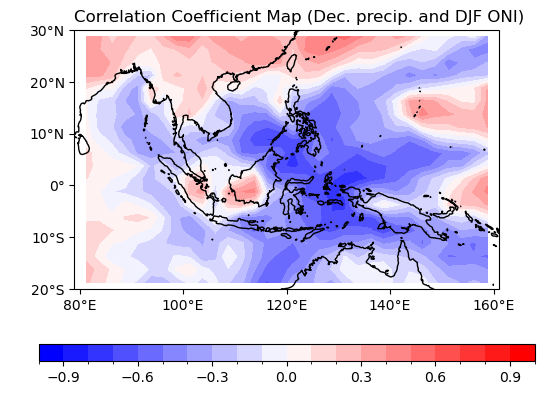

In [8]:
import numpy as np
from cartopy import crs as ccrs   
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['figure.dpi'] = 100

proj = ccrs.PlateCarree()  
fig, ax = plt.subplots(1,1,subplot_kw={'projection':proj})                  

clevs = np.arange(170,350,20)

corrPlot = (corr.plot.contourf("lon", "lat",  
                               ax=ax,       
                               levels=np.arange(-1,1.1,0.1), 
                               cmap='bwr',  
                               add_colorbar=True, 
                               extend='neither', 
                               cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': ' '}) #設定color bar
                               )
ax.set_extent([lon1,lon2,lats,latn],crs=proj)
ax.set_xticks(np.arange(80,180,20), crs=proj)
ax.set_yticks(np.arange(-20,40,10), crs=proj)
lon_formatter = LONGITUDE_FORMATTER
lat_formatter = LATITUDE_FORMATTER   
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter) 
ax.coastlines()                              
ax.set_ylabel(' ')             # 設定坐標軸名稱。
ax.set_xlabel(' ')
ax.set_title("Correlation Coefficient Map (Dec. precip. and DJF ONI)", loc='left')
plt.show()

## Conditional Control with `where`

We can filter and select data using specified conditions. The usage is

> xarray.where(cond, x, y, keep_attrs=None) 

When True, return values from *x*, otherwise returns values from *y*.

**Example 4:** Plot the mean sea level pressure (MSLP) map in December 2021, excluding regions with altitudes higher than 3000 meters. 

Step 1: Read data: MSLP and topography. 

In [9]:
lats=0
latn=60

topo_ds = xr.open_dataset('data/etopo5.nc')
mslp_ds = xr.open_dataset('data/mslp.2021.nc')
topo = topo_ds.sel(Y=slice(lats,latn),
                   X=slice(lon1,lon2)).bath
mslp = mslp_ds.sel(time=slice('2021-12-01','2021-12-31'),
                   lat=slice(latn,lats),
                   lon=slice(lon1,lon2)).mslp
mslp = mslp/100. # Convert to hPa. 

In this example, the grid resolution of the conditional array (`topo`) and the `mslp` array should be the same so that xarray can look for corresponding grids that satisfy the condition. Therefore, we need to regrid the data first.

In [21]:
topo_rmp = topo.interp(X=mslp.lon, Y=mslp.lat).drop_vars(['X','Y'])

<xarray.DataArray 'bath' (lat: 25, lon: 33)> Size: 3kB
array([[ 9.1000000e+01,  9.1000000e+01,  1.2200000e+02,  1.5200000e+02,
         1.0600000e+02,  5.1800000e+02,  5.4900000e+02,  3.6600000e+02,
         3.9600000e+02,  2.7500000e+02,  4.8800000e+02,  4.4200000e+02,
         4.5700000e+02,  3.3600000e+02,  7.6200000e+02,  2.9000000e+02,
         3.5100000e+02,  5.3300000e+02,  5.0300000e+02,  4.5700000e+02,
         3.0500000e+02,  2.4400000e+02,  3.0500000e+02,  7.6200000e+02,
         7.6200000e+02,  2.1300000e+02,  3.5000000e+02,  1.3700000e+02,
         2.4400000e+02,  3.5000000e+02, -5.7000000e+01, -1.9800000e+02,
        -1.1700000e+02],
       [ 9.1000000e+01,  9.1000000e+01,  9.1000000e+01,  1.5200000e+02,
         2.1300000e+02,  2.1300000e+02,  2.1300000e+02,  2.8900000e+02,
         2.9000000e+02,  3.9600000e+02,  5.4900000e+02,  3.3500000e+02,
         7.7700000e+02,  7.3100000e+02,  8.8400000e+02,  1.5240000e+03,
         9.7500000e+02,  1.0060000e+03,  1.0210000e+03,  1.2350000e+03,
         8.6900000e+02,  7.7700000e+02,  5.1800000e+02,  8.3800000e+02,
        -4.9000000e+01, -1.6100000e+02, -1.7800000e+02, -1.5000000e+02,
        -2.1100000e+02, -4.2200000e+02, -3.9900000e+02,  2.1400000e+02,
         1.0670000e+03],
       [ 1.2200000e+02,  1.2200000e+02,  1.9800000e+02,  3.3500000e+02,
         5.3300000e+02,  4.8800000e+02,  6.1000000e+02,  8.0800000e+02,
...
        -5.0440000e+03, -4.9250000e+03, -3.5340000e+03, -2.9970000e+03,
        -4.1980000e+03],
       [-4.3630000e+03, -4.3470000e+03, -4.2490000e+03, -4.2770000e+03,
        -2.5940000e+03, -4.2540000e+03, -2.6660000e+03, -1.2200000e+02,
         0.0000000e+00,  1.5200000e+02, -5.7000000e+01, -8.0000000e+01,
        -4.1000000e+01,  4.7200000e+02,  1.1430000e+03,  1.8300000e+02,
        -4.9930000e+03, -5.2330000e+03, -3.1710000e+03, -3.0110000e+03,
        -3.7140000e+03, -3.9730000e+03, -4.2040000e+03, -4.5100000e+03,
        -4.1420000e+03, -2.9700000e+03, -4.5320000e+03, -4.5030000e+03,
        -5.4850000e+03, -4.5540000e+03, -2.8210000e+03, -2.7980000e+03,
        -3.2370000e+03],
       [-4.6990000e+03, -4.3950000e+03, -4.5390000e+03, -4.5680000e+03,
        -4.0540000e+03, -4.5090000e+03, -4.5230000e+03, -2.0340000e+03,
         2.7500000e+02,  0.0000000e+00, -2.6000000e+01, -4.0000000e+01,
         6.1000000e+01,  3.6500000e+02,  4.8800000e+02, -6.7000000e+01,
        -4.0000000e+01, -2.4460000e+03, -3.0020000e+03, -3.8700000e+02,
        -9.7000000e+01, -3.8870000e+03, -2.3470000e+03, -4.3600000e+03,
        -3.0830000e+03, -3.0900000e+03, -3.5050000e+03, -4.5650000e+03,
        -5.0010000e+03, -4.6920000e+03, -2.5840000e+03, -2.0280000e+03,
        -2.8320000e+03]], dtype=float32)
Coordinates:
  * lon      (lon) float32 132B 80.0 82.5 85.0 87.5 ... 152.5 155.0 157.5 160.0
  * lat      (lat) float32 100B 60.0 57.5 55.0 52.5 50.0 ... 7.5 5.0 2.5 0.0
Attributes:
    long_name:       topography
    note:            updated 27 Feb 1998 from NGDC CD-ROM 29 April 1993
    scale_min:       -9964.0
    colorscalename:  topographycolorscale
    scale_max:       7964.0
    ncolor:          253
    maxncolor:       253
    units:           m
    CE:              7964.0
    CS:              -9964.0
    colormap:        [0 1973790 4026644 [4026644 28] 9125192 [9125192 28] [15...

Then set the condition with `where`:

In [29]:
mslp_mean = mslp.mean('time')
mslp_mask = xr.where(topo_rmp<=3000,mslp_mean,np.nan)

The condition is `topo <= 3000`. The `False` values (those that don't satisfy the criteria) will be set as `NaN`. The `True` values will be preserved.


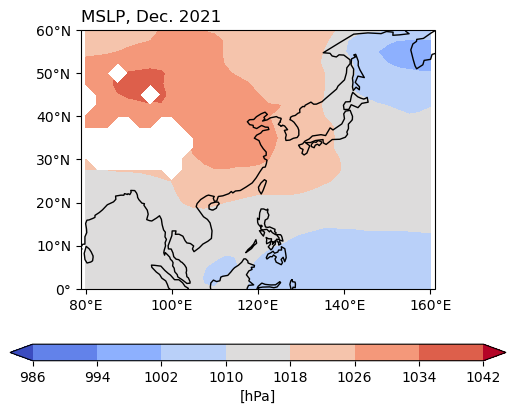

In [30]:
proj = ccrs.PlateCarree()  
fig, ax = plt.subplots(1,1,subplot_kw={'projection':proj})     

# Plotting
Plot = mslp_mask.plot.contourf("lon", "lat",  
                                ax=ax,       
                                levels=np.arange(986,1048,8), 
                                cmap='coolwarm',  
                                add_colorbar=True, 
                                extend='both', 
                                cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': '[hPa]'}) #設定color bar
ax.set_extent([lon1,lon2,lats,latn],crs=proj)
ax.set_xticks(np.arange(80,180,20), crs=proj)
ax.set_yticks(np.arange(0,70,10), crs=proj)
lon_formatter = LONGITUDE_FORMATTER
lat_formatter = LATITUDE_FORMATTER   
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter) 
ax.coastlines()                      
ax.set_ylabel(' ')  
ax.set_xlabel(' ')
ax.set_title("MSLP, Dec. 2021", loc='left')

plt.show()

Regions exceeding 3000 meters in altitude are set as `NaN`, so no values are plotted over these areas.

## Calculate Relative Vorticity and Divergence

Simple statistics can be done with xarray's methods. When it comes to meteorological variables, we can use the MetPy library. MetPy supports xarray, which means that we can apply DataArray to MetPy functions. Below is an example to calculate relative vorticity using [metpy.calc.vorticity](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.vorticity.html).

**Example 5:** Calculate relative vorticity at the 850-hPa level in December 2017.

**Step 1:** Read data and select the spatial and temporal ranges.


In [31]:
latn = 30 
lats = -20

uds = xr.open_dataset('data/ncep_r2_uv850/u850.2017.nc')
vds = xr.open_dataset('data/ncep_r2_uv850/v850.2017.nc')
u = uds.sel(time=slice('2017-12-01','2017-12-31'), 
            level=850,
            lat=slice(latn,lats),
            lon=slice(lon1,lon2)).uwnd
v = vds.sel(time=slice('2017-12-01','2017-12-31'), 
            level=850,
            lat=slice(latn,lats),
            lon=slice(lon1,lon2)).vwnd

**Step 2:** Calculate relative vorticity. Ensure that the vorticity function requires units for the wind field. Import `metpy.units` and attach it to the wind variables.

In [36]:
import metpy.calc as mpcalc
from metpy.units import units
vor = mpcalc.vorticity(u*units('m/s'), v*units('m/s'))
vorm = vor.mean(axis=0)
vorm

<xarray.DataArray (lat: 21, lon: 33)> Size: 6kB
<Quantity([[ 2.27227035e-06 -6.35822645e-06 -1.46749070e-05 -2.08053115e-05
  -2.30204190e-05 -2.14179636e-05 -1.73882539e-05 -1.29046760e-05
  -9.84929500e-06 -9.54206099e-06 -1.12507049e-05 -1.23807539e-05
  -1.01248504e-05 -4.97617877e-06 -9.28601335e-07 -2.13257232e-06
  -8.04519296e-06 -1.36745794e-05 -1.37081362e-05 -8.49913312e-06
  -2.77764758e-06 -1.18851542e-06 -3.59719131e-06 -6.00788240e-06
  -5.68558831e-06 -3.57765352e-06 -2.98596786e-06 -5.61280440e-06
  -9.78352706e-06 -1.28709753e-05 -1.36409031e-05 -1.30405734e-05
  -1.21284570e-05]
 [ 1.59641488e-06  1.27951490e-07 -2.96147587e-06 -6.09627077e-06
  -7.14075885e-06 -6.30349598e-06 -5.16875042e-06 -4.56615673e-06
  -4.01070010e-06 -3.29133037e-06 -3.14996178e-06 -4.03313727e-06
  -5.06772766e-06 -5.30085544e-06 -5.33611754e-06 -7.06711890e-06
  -1.08910896e-05 -1.43131536e-05 -1.42338578e-05 -1.03047389e-05
  -5.71612173e-06 -3.96175474e-06 -5.53658936e-06 -7.88921794e-06
  -8.64479278e-06 -8.03751306e-06 -8.04710263e-06 -9.82336098e-06
  -1.24495122e-05 -1.41660453e-05 -1.44190610e-05 -1.42504704e-05
  -1.44654921e-05]
 [-2.25853323e-06  1.13172266e-06  2.50715062e-06  3.24109081e-06
   4.54796451e-06  5.22032636e-06  3.42384104e-06  8.61968466e-08
...
  -8.52059086e-06 -1.10716107e-05 -1.19881288e-05 -1.13950856e-05
  -9.98141214e-06]
 [ 3.40814844e-07 -1.87193747e-06 -2.55199434e-06 -1.83217317e-06
  -7.07930811e-07 -2.45485863e-07 -7.17219789e-07 -1.21135839e-06
  -6.77305687e-07  1.98063110e-07 -8.42058040e-07 -4.36596747e-06
  -7.21982209e-06 -6.11138032e-06 -2.24744337e-06  6.50249030e-08
  -5.85517420e-07 -8.93727851e-07  1.92617077e-06  5.34523983e-06
   4.91827661e-06  6.98802749e-07 -2.36916696e-06 -8.49899076e-07
   3.18171194e-06  5.20927594e-06  3.40469449e-06 -5.15668196e-07
  -4.15454945e-06 -6.51466556e-06 -7.57468620e-06 -7.70031620e-06
  -7.32678885e-06]
 [ 3.86059996e-06  4.83366406e-07 -1.67842807e-06 -2.14714011e-06
  -1.31075583e-06 -6.41593796e-07 -9.82999754e-07 -1.46979384e-06
  -7.01365099e-07  5.12796672e-07 -4.05116393e-07 -4.63963087e-06
  -8.87224706e-06 -8.92474419e-06 -4.83957896e-06 -1.08197146e-06
  -7.43141058e-07 -2.15767543e-06 -1.95926642e-06 -1.83126193e-07
  -9.75771821e-09 -3.08505634e-06 -6.80966442e-06 -7.53604087e-06
  -4.54671714e-06 -6.88500940e-08  3.41230334e-06  4.97175514e-06
   4.77222735e-06  3.07068630e-06  7.25767405e-07 -1.38476001e-06
  -2.89335635e-06]], '1 / second')>
Coordinates:
  * lon      (lon) float32 132B 80.0 82.5 85.0 87.5 ... 152.5 155.0 157.5 160.0
  * lat      (lat) float32 84B 30.0 27.5 25.0 22.5 ... -12.5 -15.0 -17.5 -20.0
    level    float32 4B 850.0

In the preview of the variable `vorm` above, it includes information such as "Magnitude" and "Units". A DataArray with unit information is referred to as a **unit-aware array type**. When applying this DataArray to follow-up calculations, the unit information will be preserved. However, some libraries and functions other than MetPy may not recognize unit-aware array types, leading to errors. In such cases, we can use `.dequantify()` to convert it to an ordinary DataArray, which is called a **unit-naive array type**.

In [33]:
vorm.metpy.dequantify()

<xarray.DataArray (lat: 21, lon: 33)> Size: 6kB
array([[ 2.27227035e-06, -6.35822645e-06, -1.46749070e-05,
        -2.08053115e-05, -2.30204190e-05, -2.14179636e-05,
        -1.73882539e-05, -1.29046760e-05, -9.84929500e-06,
        -9.54206099e-06, -1.12507049e-05, -1.23807539e-05,
        -1.01248504e-05, -4.97617877e-06, -9.28601335e-07,
        -2.13257232e-06, -8.04519296e-06, -1.36745794e-05,
        -1.37081362e-05, -8.49913312e-06, -2.77764758e-06,
        -1.18851542e-06, -3.59719131e-06, -6.00788240e-06,
        -5.68558831e-06, -3.57765352e-06, -2.98596786e-06,
        -5.61280440e-06, -9.78352706e-06, -1.28709753e-05,
        -1.36409031e-05, -1.30405734e-05, -1.21284570e-05],
       [ 1.59641488e-06,  1.27951490e-07, -2.96147587e-06,
        -6.09627077e-06, -7.14075885e-06, -6.30349598e-06,
        -5.16875042e-06, -4.56615673e-06, -4.01070010e-06,
        -3.29133037e-06, -3.14996178e-06, -4.03313727e-06,
        -5.06772766e-06, -5.30085544e-06, -5.33611754e-06,
        -7.06711890e-06, -1.08910896e-05, -1.43131536e-05,
        -1.42338578e-05, -1.03047389e-05, -5.71612173e-06,
        -3.96175474e-06, -5.53658936e-06, -7.88921794e-06,
        -8.64479278e-06, -8.03751306e-06, -8.04710263e-06,
...
        -7.17219789e-07, -1.21135839e-06, -6.77305687e-07,
         1.98063110e-07, -8.42058040e-07, -4.36596747e-06,
        -7.21982209e-06, -6.11138032e-06, -2.24744337e-06,
         6.50249030e-08, -5.85517420e-07, -8.93727851e-07,
         1.92617077e-06,  5.34523983e-06,  4.91827661e-06,
         6.98802749e-07, -2.36916696e-06, -8.49899076e-07,
         3.18171194e-06,  5.20927594e-06,  3.40469449e-06,
        -5.15668196e-07, -4.15454945e-06, -6.51466556e-06,
        -7.57468620e-06, -7.70031620e-06, -7.32678885e-06],
       [ 3.86059996e-06,  4.83366406e-07, -1.67842807e-06,
        -2.14714011e-06, -1.31075583e-06, -6.41593796e-07,
        -9.82999754e-07, -1.46979384e-06, -7.01365099e-07,
         5.12796672e-07, -4.05116393e-07, -4.63963087e-06,
        -8.87224706e-06, -8.92474419e-06, -4.83957896e-06,
        -1.08197146e-06, -7.43141058e-07, -2.15767543e-06,
        -1.95926642e-06, -1.83126193e-07, -9.75771821e-09,
        -3.08505634e-06, -6.80966442e-06, -7.53604087e-06,
        -4.54671714e-06, -6.88500940e-08,  3.41230334e-06,
         4.97175514e-06,  4.77222735e-06,  3.07068630e-06,
         7.25767405e-07, -1.38476001e-06, -2.89335635e-06]])
Coordinates:
  * lon      (lon) float32 132B 80.0 82.5 85.0 87.5 ... 152.5 155.0 157.5 160.0
  * lat      (lat) float32 84B 30.0 27.5 25.0 22.5 ... -12.5 -15.0 -17.5 -20.0
    level    float32 4B 850.0
Attributes:
    units:    1 / second

The unit will be converted to an ordinary text attribute.

This example highlights the advantages of using `xarray.DataArray` over `numpy.array`. With `numpy.array`, you would need to specify the number of latitude and longitude axes, as well as provide the longitude and latitude arrays. However, since the latitude and longitude labels and dimension names are already stored in the `DataArray`, you only need to provide the wind DataArrays. This makes the code significantly simpler.

**Step 3:** Plotting. 

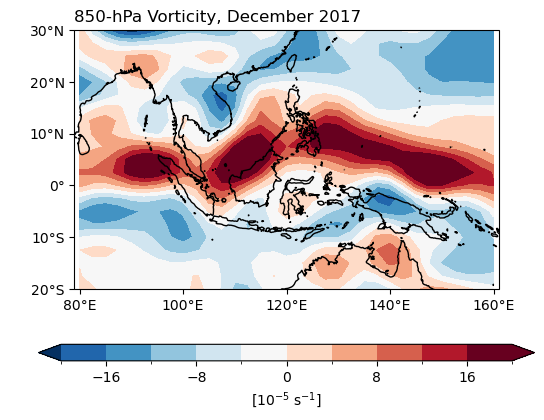

In [37]:
import cmaps

proj = ccrs.PlateCarree()  
fig, ax = plt.subplots(1,1,subplot_kw={'projection':proj}) 

vorm = vorm * 10e5
vorPlot = (vorm.plot.contourf("lon", "lat",  
                              ax=ax,       
                              levels=np.arange(-20,24,4), 
                              cmap=cmaps.CBR_coldhot,  
                              add_colorbar=True, 
                              extend='both', 
                              cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': r'[$10^{-5}$ s$^{-1}$]'}) #設定color bar
                              )
ax.set_extent([lon1,lon2,lats,latn],crs=proj)
ax.set_xticks(np.arange(80,180,20), crs=proj)
ax.set_yticks(np.arange(-20,40,10), crs=proj)
lon_formatter = LONGITUDE_FORMATTER
lat_formatter = LATITUDE_FORMATTER   
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter) 
ax.coastlines()
                         
ax.set_title(' ')
ax.set_title('850-hPa Vorticity, December 2017', loc='left')
ax.set_ylabel(' ')             # 設定坐標軸名稱。
ax.set_xlabel(' ')
plt.show()

```{admonition} Exercise
:class: tip
Similar to Example 5, but for divergence ([metpy.calc.divergence](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.divergence.html)).
```

## Empirical Orthogonal Functions (EOF)

Can use `eofs` or `xeofs` libraries. For `eofs`, see [instructions](https://ajdawson.github.io/eofs/latest/examples/xarray_examples_index.html) on their website. 

In [38]:
from eofs.xarray import Eof

Set
```
solver = Eof(data_array)
```
solver includes several methods:
- `solver.eofs()`: Calculates EOF modes. The neofs option specifies the number of modes to compute.
- `solver.pcs()`: Computes the time series of principal components.
- `solver.varianceFraction()`: Computes the ratio of variance explained by each EOF mode, indicating how much percentage of the original data variance each mode can explain.
- `solver.reconstructedField()`: Reconstructs the variable using EOF modes and their principal components.
- `solver.projectField()`: Projects the variable onto the EOF modes.

`xeof` library has more extensive EOF methods, such as multivariate EOF and rotate EOF. See [instructions](https://xeofs.readthedocs.io/en/latest/index.html) on their website.